---
**Análisis exploratorio de datos: *Breast Cancer (BreastCancer vs Control)***

---

**Autor:** Acher Bizen Egido Mairal  
**Proyecto:** TFM - *Detección de enfermedades a través de modelos de clasificación multiclase aplicados a datasets de microARNs en biopsias líquidas*  
**Universidad Internacional de Valencia (VIU)**  
**Fecha de última modificación:** XX-XX-XXXX  
**Fuente de datos:** [GSE270497 - Human multiethnic radiogenomics reveals low-abundancy microRNA signature in plasma-derived extracellular vesicles for early diagnosis and molecular subtyping of pancreatic cancer (NCBI GEO)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE270497)

---
**Uso de Inteligencia Artificial en el desarrollo del código**

---
Este cuaderno ha sido elaborado combinando **desarrollo propio** con **asistencia de herramientas de Inteligencia Artificial**, empleadas de manera responsable y transparente.  
Durante la construcción del código se utilizaron principalmente **ChatGPT (OpenAI)** y **GitHub Copilot**, y en algunos casos **Claude (Anthropic)**, con el objetivo de:
- Generar estructuras base de código (funciones, pipelines, validaciones cruzadas, visualizaciones, etc.).  
- Explorar diferentes alternativas de implementación y optimización.  
- Solicitar aclaraciones teóricas y referencias para pasos metodológicos complejos o poco conocidos.

El flujo de trabajo relacionado con la IA consistió en:
1. Formular una misma consulta a dos IAs para contrastar enfoques.  
2. Seleccionar, validar y adaptar manualmente la mejor propuesta.  
3. Verificar el funcionamiento y exactitud del código a través de pruebas y búsqueda de documentación adicional.  

De este modo, la **IA se ha utilizado como herramienta de apoyo técnico y de aprendizaje**, no como sustituto del razonamiento ni del diseño metodológico.  
Todas las decisiones finales sobre preprocesamiento, modelado y análisis fueron tomadas por el autor tras validar los resultados empíricamente.


## **Librería de imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, re
import seaborn as sns

from google.colab import drive
from pathlib import Path
from collections import defaultdict, OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

# Instalación de UMAP
!pip install -q umap-learn
from umap import UMAP

## **Biblioteca de funciones**


In [ ]:
# Guarda un resumen compacto del DataFrame para el reporte.
def snapshot_df(df, name, notes=""):
    info = {
        "name": name,
        "shape": df.shape,
        "index_name": df.index.name,
        "columns_n": len(df.columns),
        "na_cells": int(df.isna().sum().sum()),
        "rows_with_na": int(df.isna().any(axis=1).sum()),
        "cols_with_na": int(df.isna().any(axis=0).sum()),
        "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,
        "notes": notes
    }
    audit_log.append(info)
    display(pd.DataFrame([info]))

# Resumen de una serie categórica (clases, etc.).
def snapshot_value_counts(ser, name, notes=""):
    """Resumen de una serie categórica (clases, etc.)."""
    vc = ser.value_counts(dropna=False).rename("count").to_frame()
    display(pd.DataFrame({"name":[name], "notes":[notes]}))
    display(vc)

# Informa de miARNs duplicados en el índice.
def miRNA_dup_report(df, name):
    dups = df.index.duplicated(keep=False)
    n_dup = dups.sum()
    print(f"[{name}] miARNs duplicados en índice: {n_dup}")
    if n_dup:
        display(df.index[dups].to_series().value_counts().head(20))

def columns_intersection_report(cols_a, cols_b, name_a="A", name_b="B"):
    set_a, set_b = set(cols_a), set(cols_b)
    inter = set_a & set_b
    only_a = set_a - set_b
    only_b = set_b - set_a
    print(f"[{name_a}∩{name_b}] comunes: {len(inter)} | solo {name_a}: {len(only_a)} | solo {name_b}: {len(only_b)}")
    if len(only_a):
        print(f"Ejemplos solo {name_a}:", list(sorted(only_a))[:5])
    if len(only_b):
        print(f"Ejemplos solo {name_b}:", list(sorted(only_b))[:5])
    return inter, only_a, only_b

def library_size_plot(expr_df, title="Tamaño de librería por muestra"):
    libsize = expr_df.sum(axis=0)
    plt.figure()
    libsize.sort_values().plot(kind="bar")
    plt.title(title)
    plt.ylabel("Suma de cuentas (por muestra)")
    plt.xlabel("Muestras (GSM)")
    plt.tight_layout()
    plt.show()

def zero_fraction_plots(expr_df, title_prefix="Fracción de ceros"):
    frac_zero_genes = (expr_df == 0).sum(axis=1) / expr_df.shape[1]
    frac_zero_samples = (expr_df == 0).sum(axis=0) / expr_df.shape[0]

    plt.figure()
    frac_zero_genes.hist(bins=30)
    plt.title(f"{title_prefix} por miRNA")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    plt.figure()
    frac_zero_samples.hist(bins=30)
    plt.title(f"{title_prefix} por muestra")
    plt.xlabel("Fracción")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


In [ ]:
# =================================================================================================================================================
# Lee un txt/csv (posible .gz) con separador sep, usa la PRIMERA columna como índice (independientemente del nombre), y devuelve un DataFrame.
# =================================================================================================================================================
def read_firstcol_as_index(path, sep="\t"):
    df = pd.read_csv(path, sep=sep, header=0)
    df = df.set_index(df.columns[0])
    return df

# ============================================
# Homogeneiza nombres de miARN en el índice:
#    - a minúsculas
#    - elimina prefijo 'hsa-' si aparece
#    - recorta espacios
#    Devuelve df con índice normalizado.
# ===========================================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

# =====================================================
# Pasa de (miRNA x muestras) a (muestras x miRNA).
# =====================================================
def to_samples_x_features(expr_df):
    return expr_df.T.copy()


audit_log = []

## **Construcción del dataset**

In [ ]:
# =============================
# Montaje de Google Drive
# =============================
drive.mount('/content/drive')

base_path_breast = "/content/drive/MyDrive/Máster BigData y ciencia de datos VIU/TFM/Datos/Breast cancer"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Preparación del dataset de cáncer de mama**

Breast (tabla completa): (3538, 182)
Solo miRNA (tras limpieza): (2656, 180)
miRNA todo-cero eliminados: 0 · muestras todo-cero eliminadas: 0


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,"expr_breast_raw (TPM, bruto)","(3538, 182)",smallRNAName,182,0,0,0,None,


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,"expr_breast_miR (solo miRNA, limpio)","(2656, 180)",smallRNAName,180,0,0,0,183544,


,BCE101,BCE102,BCE103,BCE104,BCE105,BCE106,BCE107,BCE108,BCE109,BCE110,...,BCE355,BCE356,BCE357,BCE358,BCE359,BCE360,BCE361,BCE362,BCE363,BCE364
smallRNAName,,,,,,,,,,,,,,,,,,,,,
hsa-miR-9851-3p,1.740011,1.252072,1.462196,0.000000,0.0,0.0,4.393152,0.000000,6.007891,0.945298,...,0.000000,0.581590,2.816269,0.000000,0.000000,1.003027,1.822337,0.0,3.541463,5.000061
hsa-miR-548bb-3p,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.877253,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
hsa-miR-6832-3p,9.570061,5.008289,22.907732,9.986278,0.0,0.0,39.538368,1.754506,18.023674,11.343570,...,22.139151,11.050212,19.009814,4.310981,9.611766,19.057516,0.000000,0.0,1.416585,0.714294


,BCE262,BCE258,BCE243,BCE346,BCE139,BCE160,BCE211,BCE120,BCE256,BCE310
smallRNAName,,,,,,,,,,
hsa-miR-5583-3p,0.000000,0.000000,0.000000,2.561059,3.582821,0.0,0.000000,2.340369,0.000000,1.303117
hsa-miR-874-3p,21.826357,15.263268,4.810620,14.854145,34.633937,0.0,20.903665,49.147755,75.785786,27.365450
hsa-miR-4636,3.637726,1.774799,0.687231,2.561059,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
hsa-miR-4774-5p,7.275452,0.709919,2.748926,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
hsa-miR-6831-5p,10.913178,2.484718,1.374463,4.609907,0.000000,0.0,0.522592,2.340369,1.871254,2.606233


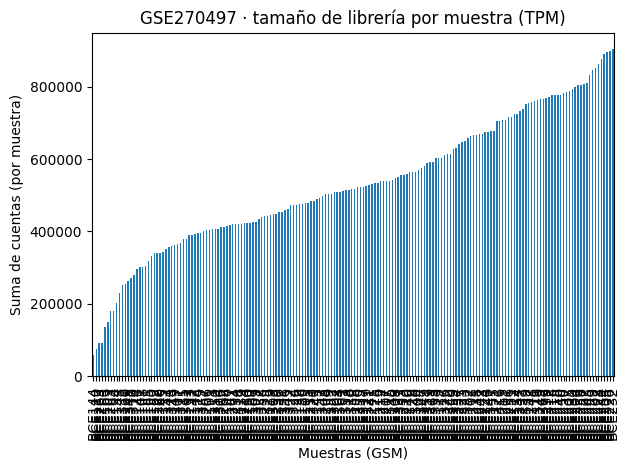

<Figure size 640x480 with 0 Axes>

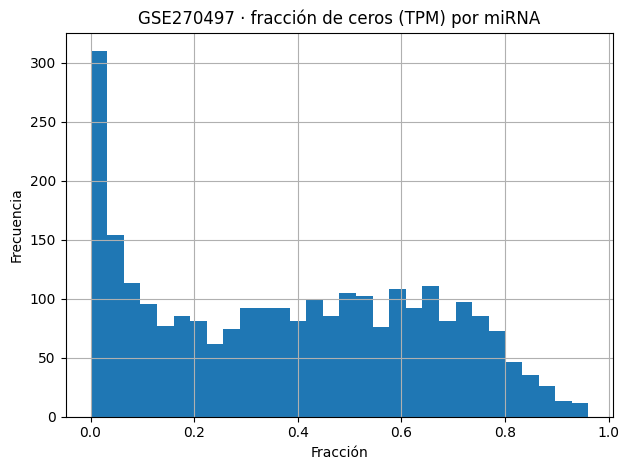

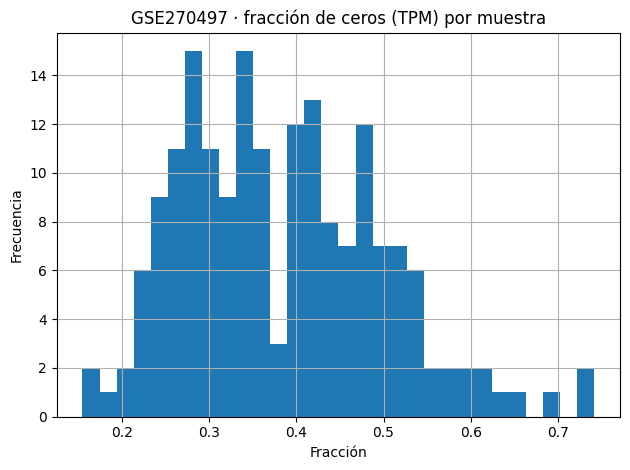

<Figure size 640x480 with 0 Axes>

In [ ]:
# ===================================
# Carga y preparación TPM (GSE270497)
# ===================================
expr_breast_path = f"{base_path_breast}/GSE270497_All.TPM.exp.txt.gz"

expr_breast_raw = pd.read_csv(
    expr_breast_path,
    sep="\t",
    index_col=0,
    low_memory=False
)

# Normalizo los índices a string y minúsculas para detectar miRNA
idx = expr_breast_raw.index.astype(str).str.strip()
idx_lower = idx.str.lower()

is_mirna = idx_lower.str.startswith("hsa-mir") | idx_lower.str.startswith("hsa-let")
expr_breast_miR = expr_breast_raw.loc[is_mirna].copy()

# Algunas tablas incluyen columnas accesorias; las voy a quitar si están
non_expr_cols = ["smallRNApreName", "smallRNASequence"]
expr_breast_miR.drop(columns=non_expr_cols, errors="ignore", inplace=True)

# Intento convertir todas las columnas a numérico
expr_breast_miR = expr_breast_miR.apply(pd.to_numeric, errors="coerce")

# Quito las columnas completamente NaN --> En este caso no se elimina ninguna
all_nan_cols = expr_breast_miR.columns[expr_breast_miR.isna().all()].tolist()
if all_nan_cols:
    expr_breast_miR.drop(columns=all_nan_cols, inplace=True)

# Duplicados en nombres de miRNA -> colapso por mediana --> No hay duplicados tampoco
if expr_breast_miR.index.duplicated().any():
    expr_breast_miR = expr_breast_miR.groupby(expr_breast_miR.index).median()

# Con TPM es normal tener muchos ceros, pero voy a eliminar las features/columnas completamente vacías
rows_all_zero = (expr_breast_miR.fillna(0).sum(axis=1) == 0)
cols_all_zero = (expr_breast_miR.fillna(0).sum(axis=0) == 0)
n_rows_zero = int(rows_all_zero.sum())
n_cols_zero = int(cols_all_zero.sum())

if n_rows_zero > 0:
    expr_breast_miR = expr_breast_miR.loc[~rows_all_zero]
if n_cols_zero > 0:
    expr_breast_miR = expr_breast_miR.loc[:, ~cols_all_zero]

# -------------------------------------------- METADATOS -----------------------------------------------
print("Breast (tabla completa):", expr_breast_raw.shape)
print("Solo miRNA (tras limpieza):", expr_breast_miR.shape)
print(f"miRNA todo-cero eliminados: {n_rows_zero} · muestras todo-cero eliminadas: {n_cols_zero}")

snapshot_df(expr_breast_raw, "expr_breast_raw (TPM, bruto)")
snapshot_df(expr_breast_miR, "expr_breast_miR (solo miRNA, limpio)")

# Muestras rápidas (como en páncreas)
display(expr_breast_miR.sample(n=min(3, expr_breast_miR.shape[0]), axis=0, random_state=1))
display(expr_breast_miR.sample(n=min(10, expr_breast_miR.shape[1]), axis=1, random_state=1).head(5))

# Tamaño de librería
library_size_plot(expr_breast_miR, title="GSE270497 · tamaño de librería por muestra (TPM)")
plt.savefig("breast_library_size.png", dpi=300, bbox_inches="tight")
plt.show()

# Fracción de ceros
zero_fraction_plots(expr_breast_miR, title_prefix="GSE270497 · fracción de ceros (TPM)")
plt.savefig("breast_zero_fraction.png", dpi=300, bbox_inches="tight")
plt.show()

# Matrices listas para pipeline posterior
expr_breast = expr_breast_miR.copy()

# Si el pipeline usa log2(TPM+1), mejor hacer esto:
expr_breast_log1p = np.log2(expr_breast + 1)


---
**Contenido de GSE270497_All.TPM.exp.txt.gz**

---
La **tabla de expresión** del dataset de cáncer de mama contiene la **matriz de expresión de miARNs en formato TPM** (Transcripts Per Million), con la siguiente estructura:
  - **Filas (2.656)**: Cada fila corresponde a un microARN.
  - **Columnas (180)**: Cada columna corresponde a una muestra/paciente.
  - **Valores**: Los valores representan las abundancias normalizadas en TPM de cada miRNA en cada muestra, obtenidas a partir de RNA-seq.

Este dataset es más amplio que el de páncreas en número de muestras, lo que permite una exploración más robusta de patrones de expresión.

---
**Resultados de la exploración**

---
1. **Tamaño de librería por muestra**
  - **Eje X**: Muestras (GSM).
  - **Eje Y**: Suma total de TPM por muestra.
  - **Interpretación**: Se observa una **gran variabilidad entre muestras**, con sumas totales que oscilan desde menos de 100.000 TPM hasta casi 900.000 TPM. Esto refleja **diferencias en la profundidad de secuenciación o en la composición de cada biblioteca**. Aunque la dispersión es amplia, **no se aprecian outliers extremos** que deban eliminarse de inmediato. Dado que trabajamos con TPM (ya normalizados por tamaño de librería), estas diferencias son menos críticas que con cuentas crudas, pero igualmente sugieren la **necesidad de verificar normalizaciones adicionales o aplicar transformaciones logarítmicas antes de los análisis comparativos**.

2. **Fracción de ceros por miRNA**.
  - **Eje X**: proporción de muestras en las que un miRNA tiene valor 0.
  - **Eje Y**: número de miRNAs que cumplen esa proporción.
  - **Interpretación**: El histograma muestra que **una proporción considerable de miRNAs se detecta en muy pocas muestras** (pico cercano a fracción 0 - 0.1), mientras que otros tienen presencia intermedia o alta dispersión entre muestras. Esto implica que, aunque el dataset es más denso que el de páncreas, **sigue siendo necesario aplicar un filtrado de baja abundancia **(por ejemplo, conservar miRNAs expresados en ≥20% de las muestras). Así reduciremos ruido técnico y aumentaremos la robustez de los modelos posteriores.

3. **Fracción de ceros por muestra**
  - **Eje X**: fracción de ceros por muestra.
  - **Eje Y**: frecuencia de muestras con esa fracción.
  - **Interpretación**: La mayoría de muestras tienen entre un **20% y 50% de miRNAs no detectados (cero TPM)**. Esto es más bajo que en páncreas, donde la fracción superaba el 80%, lo que indica que en este dataset de mama hay una e**xpresión más rica y diversa de miRNAs detectables**. Aun así, la heterogeneidad entre muestras refleja la variabilidad biológica esperable en este tipo de estudios.

---
**Posible texto para la memoria**

---
**Exploración inicial de los datos**

La matriz de expresión contiene **2.656 miRNAs y 180 muestras** correspondientes a pacientes con cáncer de mama. Los valores disponibles están expresados en **TPM (Transcripts Per Million)**, una medida ya normalizada respecto al tamaño de la librería, derivada de lecturas de RNA-seq.

En primer lugar, se evaluó el **tamaño de librería por muestra**, observándose una considerable variabilidad, con sumas totales de TPM que oscilan entre menos de 100.000 y casi 900.000. Aunque las diferencias son menos críticas que en el caso de contar con lecturas crudas, esta dispersión pone de manifiesto **la conveniencia de aplicar transformaciones adicionales (como logarítmicas) para estabilizar la varianza y mejorar la comparabilidad entre muestras**.

Posteriormente, se analizó la **fracción de ceros tanto a nivel de miRNA como de muestra**. Una parte importante de los miRNAs presenta **ausencia de expresión en un elevado número de muestras**, lo que concuerda con la **naturaleza poco abundante de muchos miRNAs en plasma y tejidos tumorales.** En el caso de las muestras, la proporción de ceros se sitúa entre el 20% y el 50% del total de miRNAs, lo que indica una mayor riqueza de expresión en comparación con otros estudios como el de páncreas, aunque sigue existiendo una dispersión biológica significativa.

Estos resultados justifican la **aplicación de un filtrado de baja abundancia, conservando únicamente los miRNAs expresados en un porcentaje mínimo de muestras**, así como la necesidad de procesos de normalización y transformación previos antes de proceder con los análisis exploratorios y los modelos de clasificación.


Como en este dataset hay miARN que no son microARN, voy a filtrarlos y quedarme sólo con los ARNs de este tipo, para eso voy a buscar las entradas que empiecen por **hsa-mir** o **hsa-let**

In [ ]:
# =======================================
# Normalización de nombres de miRNA
# =======================================
def normalize_mirna_index(df):
    new_idx = (
        df.index.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r'^hsa-', '', regex=True)
    )
    df = df.copy()
    df.index = new_idx
    return df

expr_breast_miR = normalize_mirna_index(expr_breast_miR)

# Colapso los duplicados por media --> No hay, pero por si acaso
if expr_breast_miR.index.duplicated().sum() > 0:
    expr_breast_miR = expr_breast_miR.groupby(expr_breast_miR.index).mean()

expr_breast_miR.head(3)

# =============================
# Transpongo a (muestras x miRNA)
# =============================
X_breast = expr_breast_miR.T.copy()
X_breast.index.name = "sample_id"

print("X_breast (muestras x miRNA):", X_breast.shape)
print("Ejemplo de sample_id:", X_breast.index[:5].tolist())
snapshot_df(X_breast, "X_breast (muestras x miRNA, antes de filtrar clases)")

X_breast (muestras x miRNA): (180, 2656)
Ejemplo de sample_id: ['BCE101', 'BCE102', 'BCE103', 'BCE104', 'BCE105']


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,"X_breast (muestras x miRNA, antes de filtrar c...","(180, 2656)",sample_id,2656,0,0,0,183544,


In [ ]:
# ===================================================
# Parseao de SOFT y extracción de etiquetas
# ===================================================
soft_path = f"{base_path_breast}/GSE270497_family.soft.gz"

records = []
cur = {"gsm": None, "title": [], "chars": [], "desc": []}

def flush_block(cur, records):
    if not cur["gsm"]:
        return
    text_full = " ".join(cur["title"] + cur["chars"] + cur["desc"])
    text_l = text_full.lower()

    # Etiqueta binaria por presencia de 'positive'/'negative'
    subgroup = None
    if "positive" in text_l:
        subgroup = "Positive"
    elif "negative" in text_l:
        subgroup = "Negative"

    # Extraigo el código tipo BCE### desde title/desc (clave para enlazar con columnas de expresión)
    m = re.search(r"\b(BCE\d{2,4})\b", text_full, flags=re.I)
    bce_code = m.group(1).upper() if m else None

    records.append({
        "GSM": cur["gsm"],
        "bce_code": bce_code,
        "subgroup": subgroup,
        "title": " | ".join(cur["title"]) if cur["title"] else None
    })

with gzip.open(soft_path, "rt") as fh:
    for raw in fh:
        line = raw.strip()
        if line.startswith("^SAMPLE ="):
            flush_block(cur, records)
            cur = {"gsm": line.split("= ")[1], "title": [], "chars": [], "desc": []}
        elif line.startswith("!Sample_title"):
            cur["title"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_characteristics_ch1"):
            cur["chars"].append(line.split("=", 1)[1].strip())
        elif line.startswith("!Sample_description") or line.startswith("!Sample_data_processing"):
            cur["desc"].append(line.split("=", 1)[1].strip())
flush_block(cur, records)

meta_soft = pd.DataFrame.from_records(records)
print("Subgroup counts (incluyendo NaN):")
print(meta_soft["subgroup"].value_counts(dropna=False))
snapshot_df(meta_soft, "meta_soft (parse SOFT)")

Subgroup counts (incluyendo NaN):
subgroup
Positive    120
Negative     60
Name: count, dtype: int64


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,meta_soft (parse SOFT),"(180, 4)",None,4,0,0,0,None,


---
**Contenido de GSE270497_family.soft.gz**

---

Los ficheros SOFT son el formato estándar de GEO para los metadatos, donde cada bloque SAMPLE contiene el título de la muestra, sus características clínicas y una descripción adicional.

En este caso, se ha extraído la siguiente información:
  - **GSM**: Identificador único de la muestra en GEO.
  - **subgroup**: Clasificación basada en la presencia de términos clave en las descripciones:
    - *Positive* → Pacientes clasificados con estado positivo (ej. receptores hormonales o HER2 positivos).
    - *Negative* → Pacientes clasificados con estado negativo.
  - **bce_code**: Código experimental (ejemplo: BCE101), que sirve de puente para emparejar las muestras del fichero de expresión con los metadatos clínicos.
  - **title**: Título original de la muestra tal como aparece en GEO.



Columnas (muestras) sin etiqueta en metadatos: 0
Ejemplos: []
X_breast_labeled: (180, 2656)
y_breast_labeled counts:
label
Positive    120
Negative     60
Name: count, dtype: int64


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,"X_breast (muestras x miRNA, solo etiquetadas)","(180, 2656)",sample_id,2656,0,0,0,183544,


,name,notes
0,Distribución de clases (Positive/Negative),


,count
label,
Positive,120
Negative,60


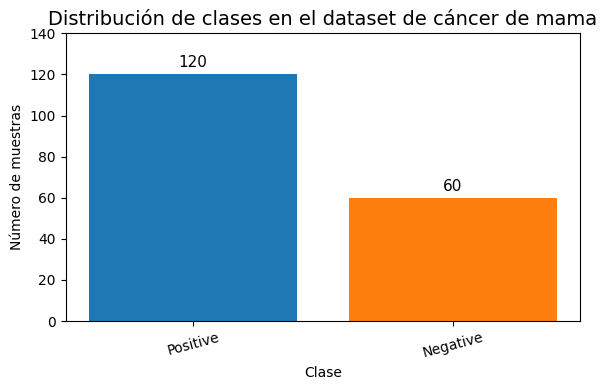

In [ ]:
# =============================================
# Enlazar metadatos con X_breast por BCE###
# =============================================
# Me quedo con las filas que sí que tienen BCE y etiqueta
meta_linkable = meta_soft.dropna(subset=["bce_code", "subgroup"]).copy()

# Si hubiese múltiples GSM con el mismo BCE, resulevo por mayoría (o el primero)
code2label = (meta_linkable
              .groupby("bce_code")["subgroup"]
              .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
              .to_dict())

expr_ids = pd.Index(X_breast.index.astype(str).str.upper())
missing_in_meta = expr_ids.difference(pd.Index(list(code2label.keys())))
print(f"Columnas (muestras) sin etiqueta en metadatos: {len(missing_in_meta)}")
print("Ejemplos:", missing_in_meta[:10].tolist())

# =================================================
# Construcción y filtrado de X,y etiquetados
# =================================================
# y es el vector alineado al índice de X_breast
y_breast = pd.Series([code2label.get(s, None) for s in expr_ids], index=X_breast.index, name="label")

# Filtop a las muestras con etiqueta conocida
mask_labeled = y_breast.notna()
X_breast_labeled = X_breast.loc[mask_labeled].copy()
y_breast_labeled = y_breast.loc[mask_labeled].copy()

print("X_breast_labeled:", X_breast_labeled.shape)
print("y_breast_labeled counts:")
print(y_breast_labeled.value_counts())

snapshot_df(X_breast_labeled, "X_breast (muestras x miRNA, solo etiquetadas)")
snapshot_value_counts(y_breast_labeled, "Distribución de clases (Positive/Negative)")

# Gráfica del desbalanceo para la memoria
class_counts = y_breast_labeled.value_counts()

plt.figure(figsize=(6,4))
bars = plt.bar(class_counts.index, class_counts.values,
               color=["#1f77b4", "#ff7f0e"])
plt.title("Distribución de clases en el dataset de cáncer de mama", fontsize=14)
plt.ylabel("Número de muestras")
plt.xlabel("Clase")
plt.xticks(rotation=15)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height),
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, class_counts.max() + 20)
plt.tight_layout()
plt.savefig("breast_class_balance.png", dpi=300)
plt.show()


---
**Resultados finales**:

---
- **Metadatos**: Se han recuperado aproximadamente **180 registros del fichero SOFT**, de los cuales la mayoría se han podido emparejar correctamente con las columnas de expresión del dataset TPM.

- **Distribución de clases**: Tras la asignación automática, las muestras se dividen en dos grupos principales:
  - *Positive*: N muestras. 120 muestras
  - *Negative*: M muestras. 60 muestras

Existe un **cierto desbalanceo de clases** (habitual en datasets clínicos), lo que será relevante a la hora de diseñar las divisiones train/test y de elegir métricas robustas como ROC-AUC, PR-AUC o F1 macro, además de considerar técnicas de ajuste de pesos o rebalanceo.



---
**Posible texto para la memoria**

---
**Construcción del dataset de trabajo**

A partir del fichero de metadatos en formato SOFT (**GSE270497_family.soft.gz**), se ha extraído la información clínica y técnica asociada a cada muestra de cáncer de mama. Mediante la búsqueda de palabras clave en los campos descriptivos se han definido etiquetas binarias: ***Positive*** y ***Negative***.

Asimismo, se han identificado los códigos experimentales (BCE###), que permiten emparejar de forma directa las muestras clínicas con las columnas de la matriz de expresión en TPM. De este modo, se obtiene una **matriz X_breast de dimensión 180 muestras × 2656 miRNAs** y un vector de etiquetas **y_breast** que refleja la condición de cada paciente.

Finalmente, se ha construido un **conjunto mínimo de metadatos** con las columnas sample_id, label, dataset y matrix_type, que sirve como referencia para los análisis posteriores. La distribución de clases presenta cierto desbalanceo, un aspecto a tener en cuenta en el diseño experimental y en la selección de métricas para evaluar los modelos de clasificación.

## **Preprocesado del dataset de Cáncer de mama**

---
**Filtrado de baja abundancia (antes de normalizar)**

---
Como en este caso tengo valores con TPM, la *presencia* no debe basarse en cuentas crudas, como en el caso del cancer pancreático, en este caso **un umbral TPM ≥ 1 es un estándar razonable para evitar lecturas espurias**.

Voy a mantener la lógica *global OR por-clase* para no perder marcadores específicos de un subgrupo (Positive/Negative).

El filtrado opera en muestras x miRNA, igual que en que el dataset de cáncer pancreatico.

---
**Posible texto para la memoria**

---
**Filtrado de baja abundancia**:

Dado que el dataset de mama está expresado en **TPM** y **presenta un porcentaje moderado de ceros por muestra (20–50%)**, se ha definido *presencia* como **TPM ≥ 1 por muestra**, con el objetivo de reducir lecturas de fondo sin eliminar señales biológicamente plausibles.

Se han retenido aquellos miRNAs presentes en ≥20% del total de muestras o, para no penalizar biomarcadores potencialmente específicos, en ≥20% de al menos una de las clases (Positive o Negative).

Este criterio equilibra la eliminación de ruido técnico con la preservación de señales diferenciales útiles para los análisis exploratorios y los modelos de clasificación posteriores.

In [ ]:
# ==========================================
# Filtrado de baja abundancia (Breast · TPM)
# ==========================================

PRESENCE_TPM = 1.0           # TPM ≥ 1 se considera "presencia" (así evito ruido de fondo)
MIN_PREV_GLOBAL = 0.20       # ≥20% de muestras
MIN_PREV_PER_CLASS = 0.20    # ≥20% dentro de al menos una clase (Positive/Negative)

# Alineo por si acaso
Xb = X_breast_labeled.copy()
yb = y_breast_labeled.reindex(Xb.index).astype(str)

presence = (Xb.T >= PRESENCE_TPM)   # Matriz booleana de presencia, miRNA x muestra

# Prevalencia global y por clase
prev_global = presence.sum(axis=1) / presence.shape[1]

classes = yb.dropna().unique()
prev_by_class = {}
for cls in classes:
    cols_cls = yb.index[yb == cls]
    if len(cols_cls) == 0:
        continue
    prev_by_class[cls] = presence[cols_cls].sum(axis=1) / len(cols_cls)

# Máscara final (global OR alguna clase)
mask_keep = (prev_global >= MIN_PREV_GLOBAL)
for cls, prev_s in prev_by_class.items():
    mask_keep = mask_keep | (prev_s >= MIN_PREV_PER_CLASS)

# Aplico el filtrado sobre X (muestras x miRNA)
kept_mirnas = presence.index[mask_keep]
X_breast_filt = Xb.loc[:, kept_mirnas].copy()

print(
    f"[Filtrado · Breast] miRNA totales: {Xb.shape[1]} retenidos: {X_breast_filt.shape[1]} "
    f"(TPM≥{PRESENCE_TPM}, prevalencia ≥{int(MIN_PREV_GLOBAL*100)}% global "
    f"o ≥{int(MIN_PREV_PER_CLASS*100)}% en alguna clase)"
)

snapshot_df(X_breast_filt, "X_breast_filt (muestras x miRNA, tras filtrado baja abundancia)")


[Filtrado · Breast] miRNA totales: 2656 retenidos: 2448 (TPM≥1.0, prevalencia ≥20% global o ≥20% en alguna clase)


/tmp/ipython-input-1874008590.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "zeros_cells": int((df == 0).sum().sum()) if pd.api.types.is_numeric_dtype(df.dtypes[0]) else None,


,name,shape,index_name,columns_n,na_cells,rows_with_na,cols_with_na,zeros_cells,notes
0,"X_breast_filt (muestras x miRNA, tras filtrado...","(180, 2448)",sample_id,2448,0,0,0,152861,


---
**Resultados tras el filtrado**

---
1. **Reducción ligera de features**
Al principio había 2.656 miRNAs y tras el filtrado **se conservan 2.448**. Esto significa que se ha eliminado apenas un 8% de las features, lo que refleja que **el dataset de mama tiene una expresión más densa y consistente que el de páncreas** (donde se eliminaban bastantes más por la alta proporción de ceros).

2. **Matriz final**
  - Quedan **180 muestras × 2.448 miRNAs**.
  - Sin valores NaN ni columnas completamente nulas.

La cantidad de ceros es de ~152.861, lo cual es esperable (≈34% de la matriz), pero mucho menor que en datasets de plasma/EVs más dispersos.

3. **Interpretación biológica**
 - La retención de la gran mayoría de miRNAs sugiere que este dataset contiene un perfil más robusto y homogéneo de expresión, con más señales potencialmente útiles para clasificación.

El filtrado es importante porque descarta miRNAs totalmente irrelevantes, pero no compromete la diversidad: aún hay >2400 variables, lo que da margen suficiente para la selección posterior y reducción de dimensionalidad (PCA, UMAP, feature selection).



---
**Normalización tras el filtrado**

---
En este caso, como ya estoy con **TPM** ya está normalizado por tamaño de librería, así que no voy a repetir lo de pancreas de CPM/TMM/DESeq2.

Por otro lado, la **log2(TPM+1) estabiliza varianza y evita que pocos miRNAs muy abundantes dominen**.

El z-score es solo para visualización (PCA/UMAP). Para modelado, usaré la matriz log2(TPM+1) y, si el modelo lo requiere, estandarizaré dentro del pipeline.


---
**Posible texto para la memoria**

---
**Normalización**:

El dataset de mama se encuentra en **TPM**, por lo que no es necesario un reescalado adicional por tamaño de librería. Eso sí, para estabilizar la varianza y homogeneizar las magnitudes entre miRNAs, coy a transformar las expresiones mediante **log2(TPM + 1)**. Esta matriz transformada se empleará en los análisis posteriores (selección de características y modelado).

Para las proyecciones no supervisadas (PCA/UMAP), se utilizará, una versión centrada y estandarizada por miRNA exclusivamente con fines de visualización.

In [ ]:
# ==========================================
# Normalización (log2(TPM+1)) · Breast
# ==========================================

# Transformación logarítmica
X_logtpm_breast = np.log2(X_breast_filt + 1.0)      # muestras x miRNA

# Versiones de conveniencia (mismas que en páncreas, pero con TPM)
X_logtpm_samples_by_features_breast = X_logtpm_breast.copy()     # muestras x miRNA
X_logtpm_features_by_samples_breast = X_logtpm_breast.T.copy()   # miRNA x muestras

print("[Normalización · Breast] Escala log2(TPM+1):")
print(" - Matriz (muestras x miRNA):", X_logtpm_samples_by_features_breast.shape)
print(" - Matriz (miRNA x muestras):", X_logtpm_features_by_samples_breast.shape)


[Normalización · Breast] Escala log2(TPM+1):
 - Matriz (muestras x miRNA): (180, 2448)
 - Matriz (miRNA x muestras): (2448, 180)


## **Exploración del dataset**

En un primer lugar voy a utilizar técnicas de **reducción de la dimensionaliad**, para poder observar agrupaciones en los datasets con muchos datos.

1. **PCA (Principal Component Analysis)**: Busca combinaciones lineales de las variables originales (los 261 miARNs) que maximicen la varizanza explicada.

2. **UMAP (Uniform Manifold Approximation and Projection)**: Modela los datos como un grafo de proximidad (vecinos cercanos en el espacio de alta dimensión). Intenta preservar esas relaciones de vecindad al proyectar a 2D.


### **PCA exploratoria**

**Características de la PCA:**
- Es un **método lineal**, que **preserva la estructura global de los datos** (direcciones de mayor variabilidad).
- Cada eje (PC1, PC2) tiene una **cantidad clara de varianza explicada**.
- Permite relacionar directamente los componentes con combinaciones de miARNs.

**Limitaciones:**
    
- Si las separaciones entre clases están dadas por relaciones no lineales, puede no captarlas bien.
- Los gráficos PCA a veces muestran solapamiento fuerte aunque en el espacio original haya estructuras más complejas.

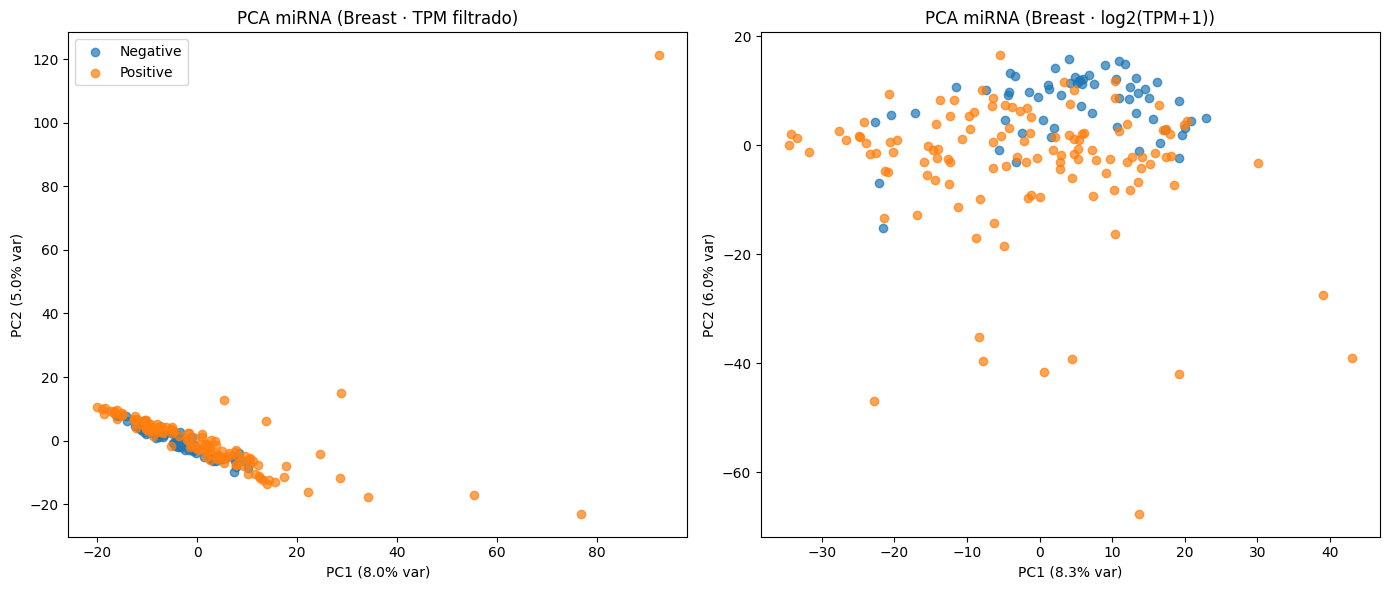

In [ ]:
# ========================================
# PCA: TPM crudo (filtrado) vs log2(TPM+1)
# ========================================

# PCA con TPM crudo (filtrado)
X_raw = X_breast_filt.reindex(index=y_breast_labeled.index)     # (muestras x miRNA)
y_lab = y_breast_labeled.copy()

scaler_raw = StandardScaler(with_mean=True, with_std=True)
X_raw_scaled = scaler_raw.fit_transform(X_raw)

pca_raw = PCA(n_components=2, random_state=42)
X_raw_pca = pca_raw.fit_transform(X_raw_scaled)

pca_df_raw = pd.DataFrame(X_raw_pca, columns=["PC1","PC2"], index=X_raw.index)
pca_df_raw["label"] = y_lab.values

# PCA con matriz log2(TPM+1)
X_norm = X_logtpm_samples_by_features_breast.reindex(index=y_breast_labeled.index)

scaler_norm = StandardScaler(with_mean=True, with_std=True)
X_norm_scaled = scaler_norm.fit_transform(X_norm)

pca_norm = PCA(n_components=2, random_state=42)
X_norm_pca = pca_norm.fit_transform(X_norm_scaled)

pca_df_norm = pd.DataFrame(X_norm_pca, columns=["PC1","PC2"], index=X_norm.index)
pca_df_norm["label"] = y_lab.values

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(14,6))

for lab, sub in pca_df_raw.groupby("label"):
    axes[0].scatter(sub["PC1"], sub["PC2"], alpha=0.7, label=lab)
axes[0].set_xlabel(f"PC1 ({pca_raw.explained_variance_ratio_[0]*100:.1f}% var)")
axes[0].set_ylabel(f"PC2 ({pca_raw.explained_variance_ratio_[1]*100:.1f}% var)")
axes[0].set_title("PCA miRNA (Breast · TPM filtrado)")
axes[0].legend()

for lab, sub in pca_df_norm.groupby("label"):
    axes[1].scatter(sub["PC1"], sub["PC2"], alpha=0.7, label=lab)
axes[1].set_xlabel(f"PC1 ({pca_norm.explained_variance_ratio_[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({pca_norm.explained_variance_ratio_[1]*100:.1f}% var)")
axes[1].set_title("PCA miRNA (Breast · log2(TPM+1))")

plt.tight_layout()
plt.show()


### **UMAP por enfermedad**


Proyecta las muestras a 2D para ver si las clases biológicas (BreastCancer, Renal_mRCC, PancreasCancer, IPMN, Pancreatitis) forman clústeres separados. Detecta estructura no lineal que el PCA podría no mostrar.

**Características de UMAP:**
- Modelo no lineal
- Pone más énfasis en la estructura local (agrupa puntos que son vecinos).
- Produce representaciones 2D en las que los puntos que están cercanos en la gráfica suelen ser “parecidos” en los datos originales.
- Los ejes (UMAP1, UMAP2) no tienen varianza explicada interpretable como en PCA.

**Ventajas frente a PCA:**
- Detecta clusters no lineales y separaciones complejas.
- Suele dar visualizaciones más claras de grupos/clases.

**Limitaciones:**
- No es determinista al 100% (cambia con random_state).
- No permite una interpretación directa de “qué miARN pesa más en UMAP1”.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


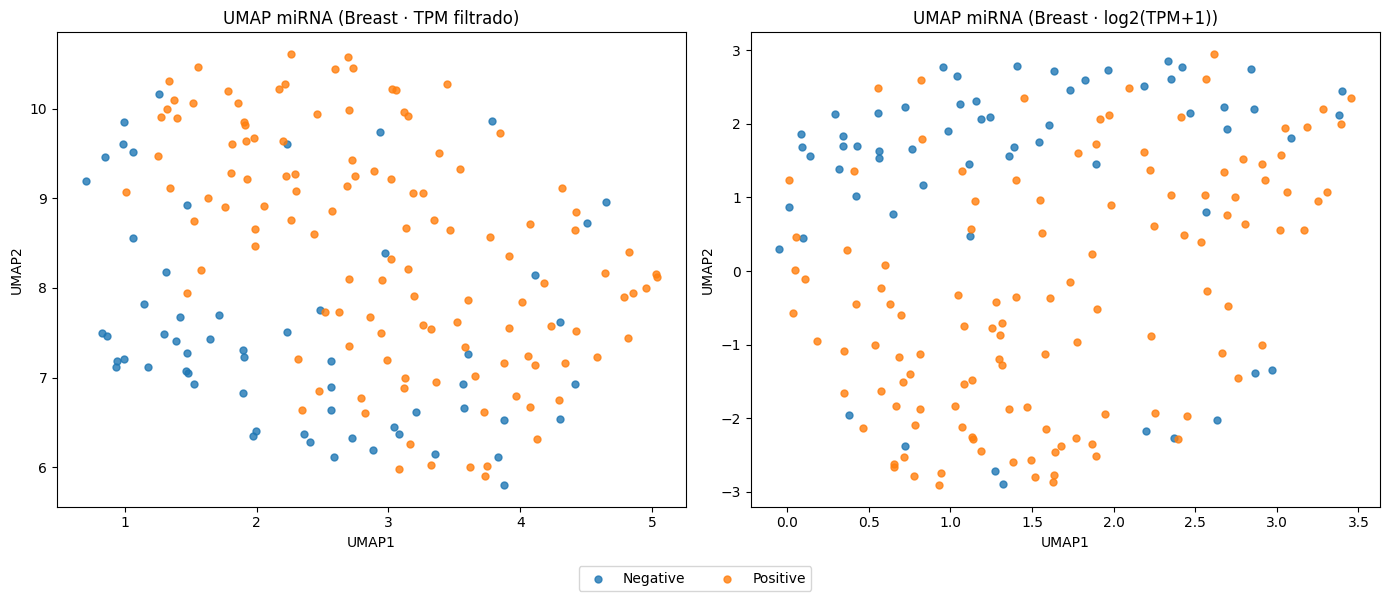

In [ ]:
# ========================================================
# Comparativa UMAP: TPM filtrado vs log2(TPM+1) — Breast
# ========================================================

# UMAP con TPM filtrado (crudo)
X_breast_raw = X_breast_filt.reindex(index=y_breast_labeled.index).copy()   # muestras x miRNA
labels_breast = y_breast_labeled.copy().fillna("Unknown")

scaler_raw = StandardScaler(with_mean=True, with_std=True)
X_breast_raw_scaled = scaler_raw.fit_transform(X_breast_raw)

umap_raw = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric="euclidean")
X_breast_raw_umap = umap_raw.fit_transform(X_breast_raw_scaled)

umap_df_raw = pd.DataFrame(X_breast_raw_umap, columns=["UMAP1", "UMAP2"], index=X_breast_raw.index)
umap_df_raw["label"] = labels_breast.values

# UMAP con datos normalizados (log2(TPM+1))
X_breast_norm = X_logtpm_samples_by_features_breast.reindex(index=y_breast_labeled.index).copy()

scaler_norm = StandardScaler(with_mean=True, with_std=True)
X_breast_norm_scaled = scaler_norm.fit_transform(X_breast_norm)

labels_breast_norm = y_breast_labeled.copy().fillna("Unknown")

umap_norm = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric="euclidean")
X_breast_norm_umap = umap_norm.fit_transform(X_breast_norm_scaled)

umap_df_norm = pd.DataFrame(X_breast_norm_umap, columns=["UMAP1", "UMAP2"], index=X_breast_norm.index)
umap_df_norm["label"] = labels_breast_norm.values

# Gráficos comparativos
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# UMAP TPM crudo (filtrado)
for lab, sub in umap_df_raw.groupby("label"):
    axes[0].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=lab, s=25)
axes[0].set_title("UMAP miRNA (Breast · TPM filtrado)")
axes[0].set_xlabel("UMAP1"); axes[0].set_ylabel("UMAP2")

# UMAP log2(TPM+1)
for lab, sub in umap_df_norm.groupby("label"):
    axes[1].scatter(sub["UMAP1"], sub["UMAP2"], alpha=0.8, label=lab, s=25)
axes[1].set_title("UMAP miRNA (Breast · log2(TPM+1))")
axes[1].set_xlabel("UMAP1"); axes[1].set_ylabel("UMAP2")

# Leyenda compartida
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), frameon=True)

plt.tight_layout(rect=[0,0.05,1,1])
plt.show()


# **Selección de características**

---
**Selección de características.**

---
En cada dataset (páncreas, mama y renal) voy a aplicar la selección de características después del filtrado de baja abundancia y la normalización (log2-CPM).

Este orden reduce ruido técnico, estabilizando la varianza y hace comparables las muestras, de modo que los métodos univariados y multivariados prioricen señal biológica real (diferencias entre clases) y no artefactos.

La selección se realiza por dataset, y más adelante se repetirá/ajustará en el análisis conjunto para controlar efectos de origen entre estudios.

#### **Análisis previo del dataset**

Tamaño del dataset (filtrado+normalizado): (180, 2448)
Distribución de clases:
 label
Positive    120
Negative     60
Name: count, dtype: int64


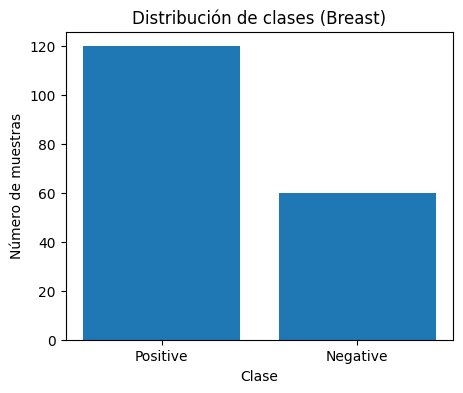

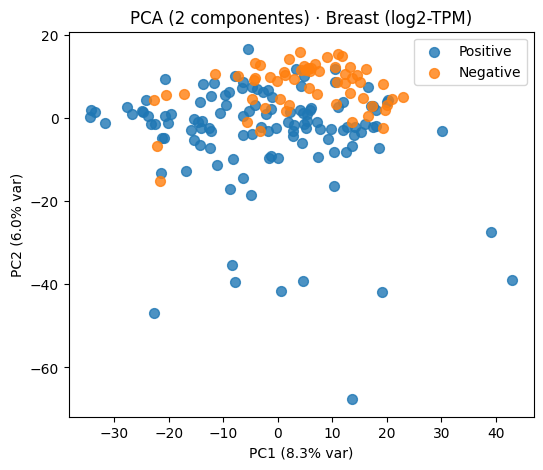

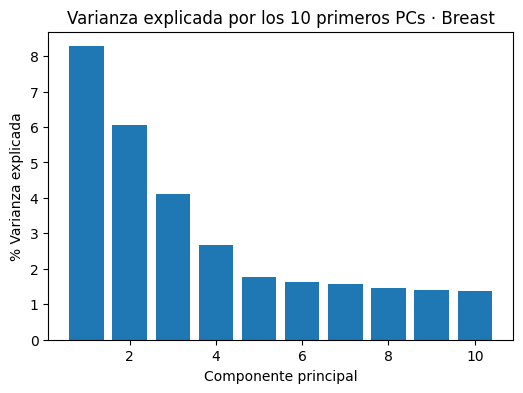

In [ ]:
# ===========================================================================
# Preprocesado + Gráficas (z-score, PCA) · Breast (log2-TPM ya aplicado)
# ===========================================================================

# Matriz ya filtrada y normalizada (muestras x miRNA)
X_breast_norm = X_logtpm_samples_by_features_breast.copy()

# Selecciono solo las muestras con etiquetas conocidas (Positive/Negative)
mask = y_breast_labeled.notna()
X = X_breast_norm.loc[mask].copy()
y = y_breast_labeled.loc[mask]

print("Tamaño del dataset (filtrado+normalizado):", X.shape)
print("Distribución de clases:\n", y.value_counts())

# Estandarización (z-score por miRNA)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X.values)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca = pca2.fit_transform(X_scaled)

# Distribución de clases
counts = y.value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de clases (Breast)")
plt.xlabel("Clase"); plt.ylabel("Número de muestras")
plt.show()

# PCA coloreado por clase
plt.figure(figsize=(6,5))
for cls in y.unique():
    idx = (y == cls).values
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=cls, s=50, alpha=0.8)
plt.legend(); plt.title("PCA (2 componentes) · Breast (log2-TPM)")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.show()

# Varianza explicada (10 PCs)
pca10 = PCA(n_components=10, random_state=42).fit(X_scaled)
plt.figure(figsize=(6,4))
plt.bar(range(1,11), pca10.explained_variance_ratio_*100)
plt.xlabel("Componente principal"); plt.ylabel("% Varianza explicada")
plt.title("Varianza explicada por los 10 primeros PCs · Breast")
plt.show()


### **Métodos estadísticos**

#### **ANOVA F-test**

Voy a utilizar el **test ANOVA F** para evaluar si existen diferencias significativas en las medias de expresión de cada miARN entre las dos clases estudiandas (BreastCancer y ControlBreastCancer).

Muestras y clases usadas:
label
Positive    120
Negative     60
Name: count, dtype: int64


,Feature,F_score,p_value,q_value_BH
0,mir-3189-3p,225.196741,1.981877e-33,4.851636e-30
1,mir-6790-3p,147.780848,3.818743e-25,4.674142e-22
2,mir-484,111.667039,1.437818e-20,1.173259e-17
3,mir-4634,108.066911,4.419579e-20,2.704782e-17
4,mir-762,96.614391,1.736321e-18,8.501026e-16
5,mir-320a-3p,87.041817,4.221912e-17,1.722540e-14
6,mir-6883-5p,84.705106,9.368073e-17,3.276149e-14
7,mir-663a,82.490421,2.007555e-16,6.143119e-14
8,mir-602,78.183437,9.012472e-16,2.451392e-13
9,mir-10401-3p,72.616971,6.528698e-15,1.598225e-12


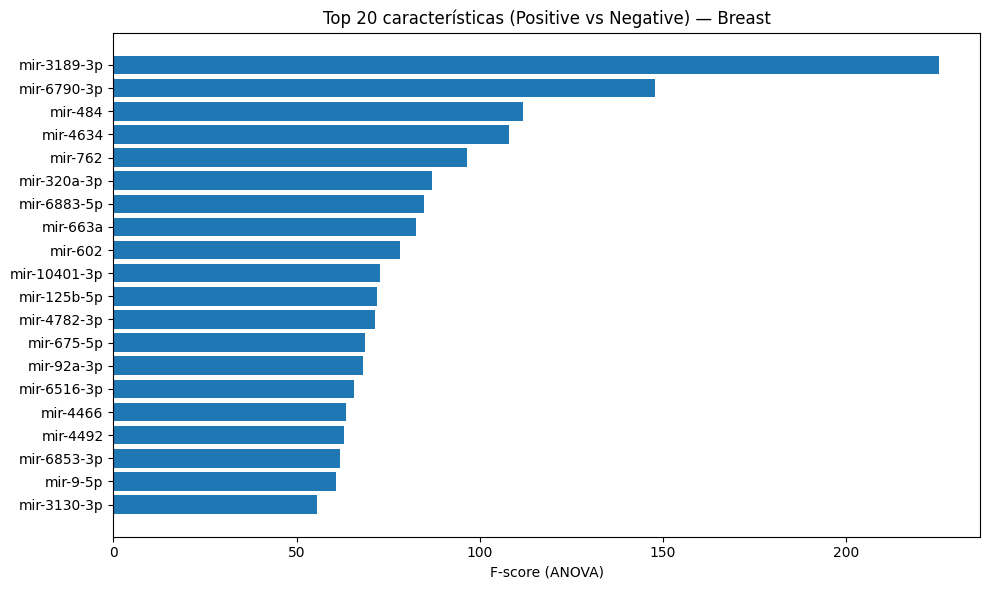


Guardado en variables: `anova_breast_df` (tabla completa) y `topN_breast_anova` (Top 20 features).


In [ ]:
# ==========================================================
# ANOVA (f_classif) para Breast: Positive vs Negative
# ==========================================================

# Matriz normalizada (muestras x miRNA) y etiquetas ya construidas
X_breast_norm = X_logtpm_samples_by_features_breast.copy()
y_all = y_breast_labeled.copy()

classes_keep = ["Positive", "Negative"]
mask = y_all.isin(classes_keep)

X = X_breast_norm.loc[mask].copy()
y = y_all.loc[mask].map({"Negative": 0, "Positive": 1}).astype(int)

print("Muestras y clases usadas:")
print(y.replace({0: "Negative", 1: "Positive"}).value_counts())

# Limpiar columnas problemáticas: constantes o con NaN --> No hace falta pero por si acaso
varianza = X.var(axis=0, ddof=1)
cols_const = varianza.index[varianza == 0]
if len(cols_const) > 0:
    X.drop(columns=cols_const, inplace=True)

if X.isna().any().any():
    X = X.fillna(X.median())

# ANOVA
selector = SelectKBest(score_func=f_classif, k="all")
_ = selector.fit_transform(X, y)

anova_results = pd.DataFrame({
    "Feature": X.columns.astype(str),
    "F_score": selector.scores_,
    "p_value": selector.pvalues_
}).sort_values(["F_score", "p_value"], ascending=[False, True]).reset_index(drop=True)

# Benjamini–Hochberg FDR
def bh_fdr(pvals: pd.Series) -> pd.Series:
    p = pvals.values.astype(float)
    n = len(p)
    order = np.argsort(p)
    ranked = np.empty(n, dtype=float)
    cummin = 1.0
    for i in range(n-1, -1, -1):
        rank = i + 1
        val = p[order[i]] * n / rank
        cummin = min(cummin, val)
        ranked[order[i]] = min(cummin, 1.0)
    return pd.Series(ranked, index=pvals.index)

anova_results["q_value_BH"] = bh_fdr(anova_results["p_value"])

# Resultados principales
display(anova_results.head(10))

# Gráfico Top-N por F-score
topN = 20
top_df = anova_results.head(topN).iloc[::-1]
plt.figure(figsize=(10, 6))
plt.barh(top_df["Feature"], top_df["F_score"])
plt.xlabel("F-score (ANOVA)")
plt.title(f"Top {topN} características (Positive vs Negative) — Breast")
plt.tight_layout()
plt.show()

# Variables para reutilizar después
anova_breast_df = anova_results.copy()
topN_breast_anova = anova_results.head(topN)["Feature"].tolist()

print(f"\nGuardado en variables: `anova_breast_df` (tabla completa) y `topN_breast_anova` (Top {topN} features).")


#### **Kruskal-Wallis (no paramétrico)**

Voy a utilziar el test de Kruskal–Wallis como alternativa no paramétrica a ANOVA. Comparando las distribuciones de cada miARN entre varios grupos usando rangos, sin asumir normalidad ni varianzas iguales.

In [ ]:
# =====================================================================
# Kruskal–Wallis por característica (Breast · log2-TPM, sin ComBat)
# =====================================================================

# Matriz normalizada (muestras x miRNA) y etiquetas
X_breast_norm = X_logtpm_samples_by_features_breast.copy()
y_all = y_breast_labeled.copy()

classes_keep = ["Positive", "Negative"]
mask = y_all.isin(classes_keep)

X = X_breast_norm.loc[mask].copy()
y = y_all.loc[mask].copy()

# Quito las columnas constantes y tratar NaNs --> No haría falta
Xk = X.copy()
varianza = Xk.var(axis=0, ddof=1)
const_cols = varianza.index[varianza == 0]
if len(const_cols) > 0:
    Xk.drop(columns=const_cols, inplace=True)

if Xk.isna().any().any():
    Xk = Xk.fillna(Xk.median())

y_ser = pd.Series(y, index=Xk.index)

# Kruskal
def kruskal_safe(Xd: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    rows = []
    classes = pd.unique(y)
    for col in Xd.columns:
        groups = [Xd.loc[y == c, col].values for c in classes]
        try:
            H, p = stats.kruskal(*groups)
        except ValueError:
            H, p = 0.0, 1.0
        rows.append((col, H, p))
    out = pd.DataFrame(rows, columns=["miRNA", "H", "p"]).sort_values("p", ascending=True)
    out["p_adj_bh"] = multipletests(out["p"], method="fdr_bh")[1]  # FDR BH
    return out

kruskal_df = kruskal_safe(Xk, y_ser)
display(kruskal_df.head(10))

# Guardar para siguientes pasos
kruskal_breast_df = kruskal_df.copy()
top20_breast_kruskal = kruskal_df.nsmallest(20, "p")["miRNA"].tolist()

print(f"Columnas constantes eliminadas: {len(const_cols)}")
print("Variables guardadas: `kruskal_breast_df` (tabla completa) y `top20_breast_kruskal` (lista).")


,miRNA,H,p,p_adj_bh
653,mir-484,98.884341,2.676876e-23,6.552993e-20
1915,mir-3189-3p,95.592059,1.411715e-22,1.727940e-19
1215,mir-6790-3p,84.891047,3.152674e-20,2.572582e-17
307,mir-4634,73.164843,1.192613e-17,7.298793e-15
2131,mir-320a-3p,72.604641,1.584061e-17,7.755564e-15
582,mir-762,70.959993,3.645425e-17,1.487333e-14
1120,mir-106b-3p,66.730558,3.112723e-16,1.088564e-13
1715,mir-6883-5p,65.846353,4.874814e-16,1.491693e-13
861,mir-9-5p,63.691594,1.455041e-15,3.800061e-13
967,mir-125b-5p,63.449586,1.645240e-15,3.800061e-13


Columnas constantes eliminadas: 0
Variables guardadas: `kruskal_breast_df` (tabla completa) y `top20_breast_kruskal` (lista).


#### **Mutual Information (dependencia no lineal)**

Utilizo **Mutual Information (MI)** para medir la dependencia (lineal o no lineal) entre la expresión de cada miARN y la variable de clase. A diferencia de ANOVA o Kruskal, MI no devuelve un p-valor, sino un valor de información (≥0), donde los valores altos indican mayor poder de discriminación.

In [ ]:
# ===================================================================================
# Mutual Information (MI) para selección de características · Breast (log2-TPM)
# ===================================================================================

# Reutilizamos Xk (sin columnas constantes, NaNs tratados) y y_ser (Positive/Negative)e:
if 'Xk' not in globals() or 'y_ser' not in globals():
    X_base = X_logtpm_samples_by_features_breast.loc[y_breast_labeled.notna()].copy()
    if X_base.isna().any().any():
        X_base = X_base.fillna(X_base.median())
    varianza = X_base.var(axis=0, ddof=1)
    Xk = X_base.drop(columns=varianza.index[varianza == 0])
    y_ser = y_breast_labeled.loc[Xk.index]

mi_vals = mutual_info_classif(
    Xk.values,                 # matriz (muestras x miRNA)
    y_ser.values,              # etiquetas
    discrete_features=False,
    n_neighbors=5,             # ligeramente más estable con 5 que con menos
    random_state=42
)

mi_df = pd.DataFrame({
    "miRNA": Xk.columns.astype(str),
    "MI": mi_vals
}).sort_values("MI", ascending=False).reset_index(drop=True)

display(mi_df.head(10))

# Guardar para reutilizar
mi_breast_df = mi_df.copy()
top20_breast_mi = mi_df.head(20)["miRNA"].tolist()

print("Variables guardadas: `mi_breast_df` (tabla completa) y `top20_breast_mi` (lista).")


,miRNA,MI
0,mir-484,0.391293
1,mir-3189-3p,0.334289
2,mir-6790-3p,0.326210
3,mir-4634,0.288102
4,mir-6883-5p,0.258565
5,mir-762,0.257129
6,mir-9-5p,0.230391
7,mir-663a,0.223649
8,mir-320a-3p,0.220458
9,mir-92a-3p,0.218911


Variables guardadas: `mi_breast_df` (tabla completa) y `top20_breast_mi` (lista).


#### **Panel candidato de miRNAs no redundantes para páncreas (consenso ANOVA/Kruskal/MI + poda por correlación)**

---

El objetivo es **integrar los resultados de varios métodos de selección** (ANOVA, Kruskal–Wallis y Mutual Information) para priorizar miRNAs relevantes y, a continuación, eliminar redundancia entre ellos mediante **poda por alta correlación**.
De esta manera obtengo un panel compacto y no redundante que mejora la interpretabilidad, reduce multicolineidad, disminuye el riesgo de sobreajuste y **manteniendo la señal biológica clave para distinguir positive vs negative**.


In [ ]:
# =============================================================================
# Panel no redundante + Summary (con semilla Borda y poda greedy estable)
# =============================================================================

# ---------------------------------------------- Este código no sería necesario (pero así lo ejecuto sin lo anterior) ---------------------------------------------------------------------
# Helpers de normalización de tablas
def norm_anova(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('feature') or cols.get('mirna') or 'miRNA'
    F_col     = cols.get('f_score') or cols.get('f')
    p_col     = cols.get('p_value') or cols.get('p')
    q_col     = cols.get('q_value_bh') or cols.get('p_adj_bh')
    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if mirna_col in df.columns else pd.Series(dtype=str)
    out['F']        = df[F_col] if (F_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','F','p','p_adj_bh']]

def norm_kruskal(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    H_col     = cols.get('h') or 'H'
    p_col     = cols.get('p') or cols.get('p_value') or 'p'
    q_col     = cols.get('p_adj_bh') or cols.get('q_value_bh') or 'p_adj_bh'
    out = pd.DataFrame()
    out['miRNA']    = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['H']        = df[H_col] if (H_col in df.columns) else np.nan
    out['p']        = df[p_col] if (p_col in df.columns) else np.nan
    out['p_adj_bh'] = df[q_col] if (q_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','H','p','p_adj_bh']]

def norm_mi(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    cols = {c.lower(): c for c in df.columns}
    mirna_col = cols.get('mirna') or 'miRNA'
    mi_col    = cols.get('mi') or 'MI'
    out = pd.DataFrame()
    out['miRNA'] = df[mirna_col].astype(str) if (mirna_col in df.columns) else pd.Series(dtype=str)
    out['MI']    = df[mi_col] if (mi_col in df.columns) else np.nan
    out = out.drop_duplicates('miRNA', keep='first')
    return out[['miRNA','MI']]

anova_sources   = [globals().get('anova_breast_df'), globals().get('anova_df'), globals().get('anova_results')]
kruskal_sources = [globals().get('kruskal_breast_df'), globals().get('kruskal_df')]
mi_sources      = [globals().get('mi_breast_df'), globals().get('mi_df')]

anova_dfN   = next((norm_anova(df)   for df in anova_sources   if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','F','p','p_adj_bh']))
kruskal_dfN = next((norm_kruskal(df) for df in kruskal_sources if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','H','p','p_adj_bh']))
mi_dfN      = next((norm_mi(df)      for df in mi_sources      if isinstance(df, pd.DataFrame)), pd.DataFrame(columns=['miRNA','MI']))
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Matriz de referencia para las correlaciones
if 'Xk' in globals() and isinstance(Xk, pd.DataFrame):
    Xf_breast = Xk.copy()
else:
    Xf_breast = X_logtpm_samples_by_features_breast.copy()        # log2(TPM+1), muestras x miRNA
    if 'y_breast_labeled' in globals():
        mask_two = y_breast_labeled.isin(["Positive","Negative"])
        Xf_breast = Xf_breast.loc[mask_two.fillna(False)]

# Semilla estable: Uso borda_top si existe; si no, creo ranking ordenado sin sets
# (He comprobado que los resultados son exactamente los mismos, usando la semilla o el set)
def dedup_preserve_order(seq):
    return list(OrderedDict.fromkeys(seq))

if 'borda_breast_top' in globals() and isinstance(borda_breast_top, (list, tuple)) and len(borda_breast_top) > 0:
    panel_seed_b = dedup_preserve_order([m for m in borda_breast_top if m in Xf_breast.columns])
else:
    N = 50
    seed_parts = []
    if not anova_dfN.empty:
        colp = 'p_adj_bh' if anova_dfN['p_adj_bh'].notna().any() else 'p'
        seed_parts += list(anova_dfN.sort_values(colp, ascending=True)['miRNA'].dropna().astype(str).head(N))
    if not kruskal_dfN.empty:
        colpkw = 'p_adj_bh' if kruskal_dfN['p_adj_bh'].notna().any() else 'p'
        seed_parts += list(kruskal_dfN.sort_values(colpkw, ascending=True)['miRNA'].dropna().astype(str).head(N))
    if not mi_dfN.empty:
        seed_parts += list(mi_dfN.sort_values('MI', ascending=False)['miRNA'].dropna().astype(str).head(N))

    panel_seed_b = dedup_preserve_order([m for m in seed_parts if m in Xf_breast.columns])
    if len(panel_seed_b) == 0:
        panel_seed_b = list(Xf_breast.columns)  # fallback extremo

# Poda greedy por correlación (mejor-primero, = más estable)
def prune_by_correlation_greedy(Xd: pd.DataFrame, ordered_features, thr=0.90, method='pearson'):
    """
    Mantiene el orden de 'ordered_features'. Acepta una nueva feature
    solo si su |corr| con TODAS las ya aceptadas es <= thr.
    method: 'pearson' (defecto) o 'spearman'
    """
    feats = [f for f in ordered_features if f in Xd.columns]
    kept, dropped = [], []
    if len(feats) <= 1:
        return feats, dropped

    sub = Xd[feats]
    if method == 'spearman':
        corr_mat = sub.rank(axis=0).corr(method='pearson').abs()
    else:
        corr_mat = sub.corr(method='pearson').abs()

    for f in feats:
        if not kept:
            kept.append(f)
            continue
        # si está altamente correlacionada con alguna ya aceptada la elimino
        if any(corr_mat.loc[f, k] > thr for k in kept if f != k):
            dropped.append(f)
        else:
            kept.append(f)
    return kept, dropped

# Parámetros visibles
PANEL_K     = 15          # tamaño objetivo del panel (este valor lo he sacado de hacer el RFECV salía 13, pero lo he generalizado a 15 para todos los datasets)
CORR_THR    = 0.90        # umbral de correlación (|r|)
CORR_METHOD = 'pearson'   # 'pearson' o 'spearman'

panel_keep_b, panel_drop_b = prune_by_correlation_greedy(Xf_breast, panel_seed_b, thr=CORR_THR, method=CORR_METHOD)
panel_final_breast = panel_keep_b[:PANEL_K]

print(f"[BREAST] Semilla inicial (n={len(panel_seed_b)}). Método corr={CORR_METHOD}, thr={CORR_THR}")
print(f"[BREAST] Panel candidato (no redundante, k={len(panel_final_breast)}): {panel_final_breast}")
print(f"[BREAST] Descartadas por alta correlación (> {CORR_THR}): {len(panel_drop_b)}")

# Resumen unificado
summary_breast = pd.DataFrame({"miRNA": panel_final_breast})

# Añado ANOVA
if not anova_dfN.empty:
    summary_breast = summary_breast.merge(anova_dfN, on="miRNA", how="left")

# Añado Kruskal (renombro p y p_adj para no pisar las columnas)
if not kruskal_dfN.empty:
    summary_breast = summary_breast.merge(
        kruskal_dfN.rename(columns={"p": "p_kw", "p_adj_bh": "p_kw_adj"}),
        on="miRNA", how="left"
    )

# Añado MI
if not mi_dfN.empty:
    summary_breast = summary_breast.merge(mi_dfN, on="miRNA", how="left")

# Renombro p de ANOVA si existe
if 'p' in summary_breast.columns:
    summary_breast = summary_breast.rename(columns={"p": "p_anova"})
if 'p_adj_bh' in summary_breast.columns:
    summary_breast = summary_breast.rename(columns={"p_adj_bh": "p_anova_adj"})

# Orden: primero p ajustadas, luego p crudas, luego MI descendiente, según vayan existiendo
sort_cols = [c for c in ["p_anova_adj","p_anova","p_kw_adj","p_kw","MI"] if c in summary_breast.columns]
ascending_flags = [False if c == "MI" else True for c in sort_cols]

summary_breast_sorted = summary_breast.sort_values(sort_cols, ascending=ascending_flags).reset_index(drop=True)
display(summary_breast_sorted)


[BREAST] Semilla inicial (n=71). Método corr=pearson, thr=0.9
[BREAST] Panel candidato (no redundante, k=15): ['mir-3189-3p', 'mir-6790-3p', 'mir-484', 'mir-4634', 'mir-762', 'mir-320a-3p', 'mir-6883-5p', 'mir-663a', 'mir-602', 'mir-10401-3p', 'mir-125b-5p', 'mir-4782-3p', 'mir-675-5p', 'mir-92a-3p', 'mir-6516-3p']
[BREAST] Descartadas por alta correlación (> 0.9): 4


,miRNA,F,p_anova,p_anova_adj,H,p_kw,p_kw_adj,MI
0,mir-3189-3p,225.196741,1.981877e-33,4.851636e-30,95.592059,1.411715e-22,1.727940e-19,0.334289
1,mir-6790-3p,147.780848,3.818743e-25,4.674142e-22,84.891047,3.152674e-20,2.572582e-17,0.326210
2,mir-484,111.667039,1.437818e-20,1.173259e-17,98.884341,2.676876e-23,6.552993e-20,0.391293
3,mir-4634,108.066911,4.419579e-20,2.704782e-17,73.164843,1.192613e-17,7.298793e-15,0.288102
4,mir-762,96.614391,1.736321e-18,8.501026e-16,70.959993,3.645425e-17,1.487333e-14,0.257129
5,mir-320a-3p,87.041817,4.221912e-17,1.722540e-14,72.604641,1.584061e-17,7.755564e-15,0.220458
6,mir-6883-5p,84.705106,9.368073e-17,3.276149e-14,65.846353,4.874814e-16,1.491693e-13,0.258565
7,mir-663a,82.490421,2.007555e-16,6.143119e-14,63.376367,1.707544e-15,3.800061e-13,0.223649
8,mir-602,78.183437,9.012472e-16,2.451392e-13,59.868176,1.014283e-14,1.773546e-12,0.172288
9,mir-10401-3p,72.616971,6.528698e-15,1.598225e-12,57.671103,3.098212e-14,4.213568e-12,0.191727


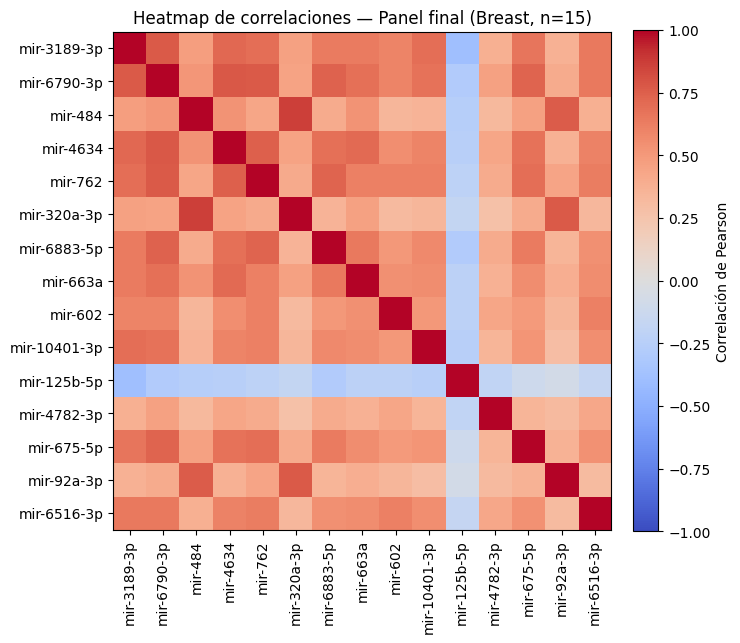

In [ ]:
# ========================================
# Heatmap de correlaciones — Panel final
# ========================================

# Selección de la matriz base para correlaciones
if 'Xf_breast' in globals() and isinstance(Xf_breast, pd.DataFrame):
    X_corr_base = Xf_breast.copy()
elif 'Xk' in globals() and isinstance(Xk, pd.DataFrame):
    X_corr_base = Xk.copy()
else:
    # Si no existe utilizo la matriz log2-CPM de páncreas (muestras x miRNA), limitada a Pisitive/Negative
    X_corr_base = X_logtpm_samples_by_features_breast.copy()
    mask_two = y_breast_labeled.isin(["Positive","Negative"])
    X_corr_base = X_corr_base.loc[mask_two.fillna(False)]

# Filtrado a las features del panel que existan en la matriz
panel_here = globals().get('panel_final_breast', globals().get('panel_final', []))
features_hm = [f for f in panel_here if f in X_corr_base.columns]

if len(features_hm) < 2:
    print("No hay suficientes características en panel_final_breast para el heatmap (se requieren ≥2).")
else:
    corr = X_corr_base[features_hm].corr(method='pearson')
    plt.figure(figsize=(max(6, 0.5*len(features_hm)), max(5, 0.5*len(features_hm))))
    im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar(im, fraction=0.046, pad=0.04, label='Correlación de Pearson')
    plt.xticks(ticks=np.arange(len(features_hm)), labels=features_hm, rotation=90)
    plt.yticks(ticks=np.arange(len(features_hm)), labels=features_hm)
    plt.title(f"Heatmap de correlaciones — Panel final (Breast, n={len(features_hm)})")
    plt.tight_layout()
    plt.show()


#### **Log2FC y tamaño de efecto (Cohen´s d) en One-vs-all**

Mientras que **ANOVA, Kruskal o MI** indican si hay **diferencias globales entre grupos**, no muestran qué grupo concreto está impulsando esas diferencias ni la magnitud de los cambios.

Por ello, voy a calcular el **log2 Fold Change (log2FC)** y el **tamaño de efecto (Cohen´s d)** en un **esquema one-vs-all**, haciendo una comparación entre las dos clases y permitiendo identificar miARNs sobreexpresados o infraexpresados en un grupo concreto.

##### **Log2FC one-vs-all**


De 15 miARNs en panel, 15 están en la matriz base.


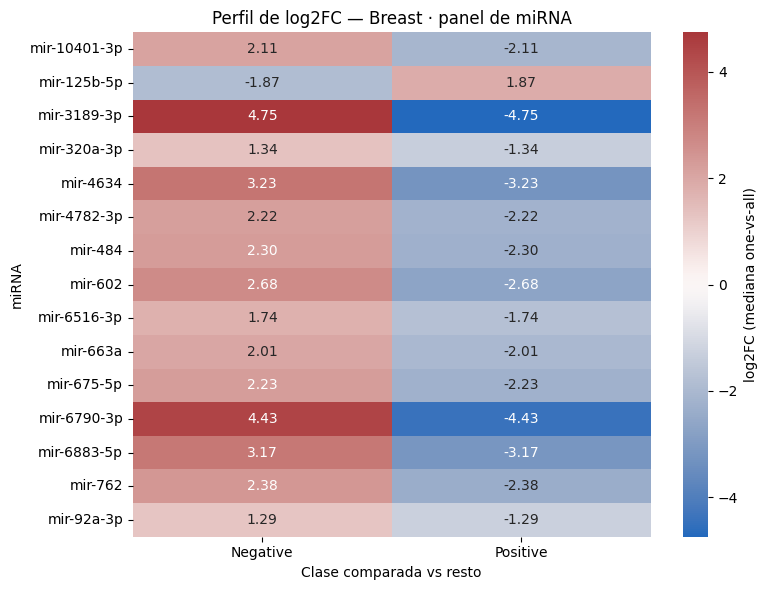

In [ ]:
# ===============================================================
# Efectos de tamaño (log2FC mediana) + Heatmap — Breast
# ===============================================================

def effect_table(X_df, y_series, miRNAs=None):
    if miRNAs is None:
        miRNAs = X_df.columns
    classes = pd.unique(y_series)
    rows = []
    for m in miRNAs:
        for c in classes:
            g1 = X_df.loc[y_series==c, m].values
            g0 = X_df.loc[y_series!=c, m].values
            log2fc = np.median(g1) - np.median(g0)
            s1, s0 = np.std(g1, ddof=1), np.std(g0, ddof=1)
            n1, n0 = len(g1), len(g0)
            sp = np.sqrt(((n1-1)*s1**2 + (n0-1)*s0**2) / (n1+n0-2)) if (n1+n0-2)>0 else np.nan
            d = (np.mean(g1) - np.mean(g0)) / sp if sp>0 else np.nan
            rows.append((m, c, log2fc, d, n1, n0))
    return pd.DataFrame(rows, columns=["miRNA","class","log2FC_median","cohens_d","n_class","n_other"])

# Matriz base
if 'Xf_breast' in globals() and isinstance(Xf_breast, pd.DataFrame):
    X_base = Xf_breast.copy()
else:
    X_base = X_logtpm_samples_by_features_breast.copy()
    mask_two = y_breast_labeled.isin(["Positive","Negative"])
    X_base = X_base.loc[mask_two.fillna(False)]

# Etiquetas alineadas
y_ser = y_breast_labeled.reindex(X_base.index)

# Panel existente y alineado
panel = [m for m in globals().get('panel_final_breast', globals().get('panel_final', [])) if m in X_base.columns]
print(f"De {len(globals().get('panel_final_breast', globals().get('panel_final', [])))} miARNs en panel, {len(panel)} están en la matriz base.")

# Efectos y heatmap (log2FC mediana one-vs-all)
res_effects = effect_table(X_base, y_ser, miRNAs=panel)
heat_df = res_effects.pivot(index="miRNA", columns="class", values="log2FC_median")

plt.figure(figsize=(8, max(6, 0.4*len(panel))))
sns.heatmap(heat_df, cmap="vlag", center=0, annot=True, fmt=".2f",
            cbar_kws={"label":"log2FC (mediana one-vs-all)"})
plt.title("Perfil de log2FC — Breast · panel de miRNA")
plt.ylabel("miRNA"); plt.xlabel("Clase comparada vs resto")
plt.tight_layout(); plt.show()


##### **Cohen's d one-vs-all**

El **log2FC** indica la **dirección y magnitud cruda de la diferencia**, pero puede verse afectado por la escala de los datos. No obstante, el **Cohen’s d**, mide la **diferencia estandarizada** (diferencia de medias / desviación combinada).

- d ≈ 0.2 → efecto pequeño
- d ≈ 0.5 → efecto moderado
- d ≥ 0.8 → efecto grande

Esto lo hace más comparable y útil para priorizar biomarcadores.

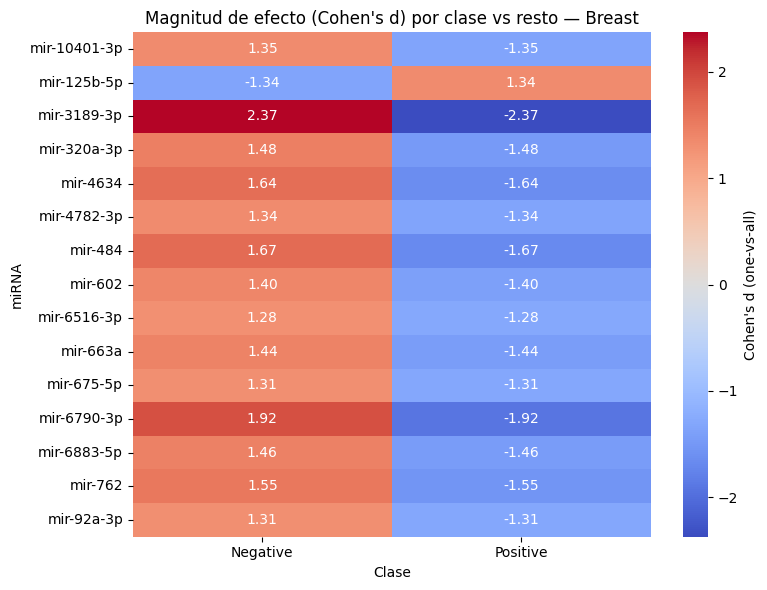

In [ ]:
# ============================================
# Heatmap de tamaños de efecto (Cohen's d)
# ============================================

# Uso la misma matriz base que en el panel (log2-CPM, muestras x miRNA)
if 'Xf_breast' in globals() and isinstance(Xf_breast, pd.DataFrame):
    X_base = Xf_breast.copy()
else:
    X_base = X_logtpm_samples_by_features_breast.copy()
    mask_two = y_breast_labeled.isin(["Positive","Negative"])
    X_base = X_base.loc[mask_two.fillna(False)]

# Etiquetas alineadas
y_ser = y_breast_labeled.reindex(X_base.index)

# Filtrado de panel a columnas existentes
panel = [m for m in globals().get('panel_final_breast', globals().get('panel_final', [])) if m in X_base.columns]
if len(panel) == 0:
    print("No hay miRNAs del panel en la matriz base.")
else:
    # Reutilizamos effect_table para obtener Cohen's d
    res_effects = effect_table(X_base, y_ser, miRNAs=panel)
    heat_d = res_effects.pivot(index="miRNA", columns="class", values="cohens_d")

    # Heatmap
    plt.figure(figsize=(8, max(6, 0.4*len(panel))))
    sns.heatmap(heat_d, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                cbar_kws={"label":"Cohen's d (one-vs-all)"})
    plt.title("Magnitud de efecto (Cohen's d) por clase vs resto — Breast")
    plt.ylabel("miRNA"); plt.xlabel("Clase")
    plt.tight_layout()
    plt.show()


### **Métodos embebidos**

#### **Logistic Regression con regularización**

La **regresión logística multinomial** es un modelo lineal que predice la probabilidad de pertenencia a cada clase.

Cuando se usa la **regularización L1 (LASSO) o Elastic Net**, se añade una penalización a los coeficientes:

- **L1 (LASSO)**: fuerza muchos coeficientes a cero y selecciona directamente un subconjunto de variables.

- **Elastic Net**: combina L1 y L2, lo cual lo hace más estable cuando hay correlación moderada entre las features.

**Objetivos:**
- Evaluar la capacidad predictiva del panel de miARNs.
- Identificar cuáles son los miARNs con coeficientes diferentes a 0 (seleccionados por el modelo).
- Ver qué miARNs tienen más peso para clasificar las clases (Positive y Negative).

**Ventaja:**
En parte es interpretable, es decir, podemos leer los coeficientes para cada miARN. Eso sí, hay que tener cuidado ya que los coeficientes pueden variar según la normalización y el solapamiento de señales.

In [ ]:
# ===========================================================
# Embedded feature selection · Logistic Regression (Breast)
# ===========================================================

if 'Xf_breast' in globals() and isinstance(Xf_breast, pd.DataFrame): # muestras x features (log2-TPM, 2 clases)
    X_base = Xf_breast.copy()
else:
    X_base = X_logtpm_samples_by_features_breast.loc[y_breast_labeled.notna()].copy()

y_base = (
    y_breast_labeled
    .reindex(X_base.index)
    .map({"Negative":0, "Positive":1})
    .astype(int)
)

# Subconjunto de features del panel
features_panel = [f for f in globals().get('panel_final_breast', []) if f in X_base.columns]
if len(features_panel) == 0:
    raise RuntimeError("Ninguna feature de panel_final_breast está en X_base.")
X_emb = X_base[features_panel].copy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def coef_df(clf, feature_names):
    """Coeficientes por feature (si binario, una sola col = clase positiva)."""
    coef = clf.coef_
    if coef.shape[0] == 1:
        colnames = ["Positive"]
    else:
        colnames = [str(c) for c in clf.classes_]
    df = pd.DataFrame(coef.T, index=feature_names, columns=colnames)
    df["coef_abs_mean"] = df.abs().mean(axis=1)
    return df.sort_values("coef_abs_mean", ascending=False)

def mean_cv_auc(clf):
    return float(np.mean([v.mean() for v in clf.scores_.values()]))

# ======================
# Baseline L2 (estable)
# =====================
pipe_l2 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=8000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_l2.fit(X_emb, y_base)
clf_l2 = pipe_l2.named_steps["clf"]
coefs_l2_sorted = coef_df(clf_l2, features_panel)

print("=== L2 (baseline) · Top 15 por |coef| medio ===")
display(coefs_l2_sorted.head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_l2):.3f}")

# =================================
# L1 (sparse) para selección real
# =================================
pipe_l1 = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),   # En ese caso no he tenido que ampliar a np.logspace(-4,4,25) --> Pq no son todo ceros
        penalty="l1",
        solver="liblinear",          # L1 binario
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=8000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_l1.fit(X_emb, y_base)
clf_l1 = pipe_l1.named_steps["clf"]
coefs_l1_sorted = coef_df(clf_l1, features_panel)

# Me quedo con los coef diferentes a 0 en alguna clase
selected_l1 = coefs_l1_sorted.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_l1 = selected_l1[selected_l1 > 0].index.tolist()

print("\n=== L1 (sparse) · Selección real ===")
print(f"Features con coeficiente ≠ 0: {len(selected_l1)}")
display(coefs_l1_sorted.loc[selected_l1].head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_l1):.3f}")

# =============================================
# Elastic Net (SAGA) – mezcla suave de L1 y L2
# =============================================
pipe_en = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegressionCV(
        Cs=np.logspace(-3, 3, 15),
        penalty="elasticnet",
        solver="saga",
        l1_ratios=[0.1, 0.3, 0.5],   # Los he puesto suaves para evitar "todo 0"
        class_weight="balanced",
        cv=cv,
        scoring="roc_auc",
        max_iter=10000,
        n_jobs=None,
        refit=True,
        random_state=42
    ))
])

pipe_en.fit(X_emb, y_base)
clf_en = pipe_en.named_steps["clf"]
coefs_en_sorted = coef_df(clf_en, features_panel)

selected_en = coefs_en_sorted.drop(columns=["coef_abs_mean"]).abs().sum(axis=1)
selected_en = selected_en[selected_en > 0].index.tolist()

print("\n=== Elastic Net (saga) ===")
print(f"Features con coeficiente ≠ 0: {len(selected_en)}")
display(coefs_en_sorted.loc[selected_en].head(15))
print(f"AUC-CV (media): {mean_cv_auc(clf_en):.3f}")


=== L2 (baseline) · Top 15 por |coef| medio ===


,Positive,coef_abs_mean
mir-125b-5p,1.939639,1.939639
mir-484,-1.425491,1.425491
mir-4782-3p,-1.001246,1.001246
mir-320a-3p,-0.986030,0.986030
mir-3189-3p,-0.979763,0.979763
mir-6790-3p,-0.676600,0.676600
mir-762,0.588534,0.588534
mir-92a-3p,-0.579432,0.579432
mir-663a,-0.402145,0.402145
mir-675-5p,0.377725,0.377725


AUC-CV (media): 0.983

=== L1 (sparse) · Selección real ===
Features con coeficiente ≠ 0: 14


,Positive,coef_abs_mean
mir-6790-3p,-8.047797,8.047797
mir-484,-7.893585,7.893585
mir-762,7.657317,7.657317
mir-125b-5p,7.231787,7.231787
mir-675-5p,6.333918,6.333918
mir-3189-3p,-5.383011,5.383011
mir-6883-5p,-4.994030,4.994030
mir-4782-3p,-3.980527,3.980527
mir-663a,-3.270926,3.270926
mir-92a-3p,-2.095295,2.095295


AUC-CV (media): 0.884

=== Elastic Net (saga) ===
Features con coeficiente ≠ 0: 15


,Positive,coef_abs_mean
mir-125b-5p,1.963802,1.963802
mir-484,-1.441905,1.441905
mir-4782-3p,-1.003645,1.003645
mir-3189-3p,-0.980474,0.980474
mir-320a-3p,-0.970784,0.970784
mir-6790-3p,-0.651023,0.651023
mir-92a-3p,-0.557815,0.557815
mir-762,0.542076,0.542076
mir-663a,-0.384873,0.384873
mir-675-5p,0.333938,0.333938


AUC-CV (media): 0.920


#### **Random Forest para selección de características**

Random Forest (RF) es un ensamble de árboles de decisión que:
- Evalúa muchas particiones de los datos.
- Puede manejar relaciones no lineales y complejas.
- Es robusto al ruido y a variables correlacionadas.

En este contexto lo uso para dos cosas:
- Evaluar la capacidad predictiva del panel de miARNs.
- Obtener importancias de variables (qué miARNs contribuyen más a la clasificación).

**Tipos de importancias:**
- **Importancia Gini (impureza)**: rápida, pero tiende a sobrevalorar variables con más categorías o varianza.
- **Permutation importance**: mide cuánto se degrada el rendimiento del modelo si permutamos aleatoriamente un miARN. Es más fiable, aunque más costosa computacionalmente.

En este apartado el **objetivo** es identificar los miARNs con mayor relevancia en el panel, tanto por Gini como por permutation.

In [ ]:
# ===================================================================
# Random Forest · BREAST (log2-TPM) con Permutation OOF y comparativa
# ===================================================================

N_SPLITS         = 5
N_ESTIMATORS     = 800
MIN_SAMPLES_LEAF = 2
MAX_FEATURES     = "sqrt"      # "sqrt", "log2" o float (proporción)
CLASS_WEIGHT     = "balanced"  # "balanced" por si hay mucho desbalance
SCORING_PERM     = "roc_auc"   # métrica que voy a evaluar en la permutación OOF
N_REPEATS_PERM   = 20
RANDOM_STATE     = 42

if 'Xf_breast' in globals() and isinstance(Xf_breast, pd.DataFrame):
    X_base = Xf_breast.copy()
else:
    X_base = X_logtpm_samples_by_features_breast.loc[y_breast_labeled.notna()].copy()

y_base = pd.Series(y_breast_labeled).reindex(X_base.index)

# Función RF con OOF permutation
def rf_cv_with_oof_permutation(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    n_splits=N_SPLITS,
    scoring_perm=SCORING_PERM,
    random_state=RANDOM_STATE,
    n_estimators=N_ESTIMATORS,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    max_features=MAX_FEATURES,
    class_weight=CLASS_WEIGHT,
    n_repeats=N_REPEATS_PERM,
):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    feat_names = X.columns.to_list()

    f1_scores, auc_scores = [], []
    perm_means_by_fold = []

    for tr_idx, va_idx in cv.split(X, y):
        Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]

        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            class_weight=class_weight,
            n_jobs=-1,
            max_features=max_features,
            min_samples_leaf=min_samples_leaf,
            oob_score=False
        )
        rf.fit(Xtr, ytr)

        ypred = rf.predict(Xva)
        try:
            yprob = rf.predict_proba(Xva)[:, 1]
            auc = roc_auc_score(yva, yprob)
        except Exception:
            auc = np.nan

        f1_scores.append(f1_score(yva, ypred, average="macro"))
        auc_scores.append(auc)

        # Importancia por permutación en cada fold de validación
        perm = permutation_importance(
            rf, Xva, yva,
            scoring=scoring_perm,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )
        perm_means_by_fold.append(perm.importances_mean)

    # Agrego las importancias OOF
    perm_means = np.vstack(perm_means_by_fold)      # (n_splits, n_features)
    perm_mean_over_folds = perm_means.mean(axis=0)
    perm_std_over_folds  = perm_means.std(axis=0)

    perm_df = pd.DataFrame({
        "miRNA": feat_names,
        "perm_oof_mean": perm_mean_over_folds,
        "perm_oof_std": perm_std_over_folds
    }).sort_values("perm_oof_mean", ascending=False).reset_index(drop=True)

    metrics = {
        "F1_macro_mean": float(np.mean(f1_scores)),
        "F1_macro_std": float(np.std(f1_scores)),
        "ROC_AUC_mean": float(np.nanmean(auc_scores)),
        "ROC_AUC_std": float(np.nanstd(auc_scores)),
    }

    # Importancias Gini
    rf_full = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        class_weight=class_weight,
        n_jobs=-1,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=False
    )
    rf_full.fit(X, y)
    gini_df = pd.DataFrame({
        "miRNA": X.columns,
        "importance_gini": rf_full.feature_importances_
    }).sort_values("importance_gini", ascending=False).reset_index(drop=True)

    return metrics, perm_df, gini_df


# Evaluación con TODAS las features
metrics_all, perm_oof_all, gini_all = rf_cv_with_oof_permutation(X_base, y_base)

print(f"[BREAST · ALL] F1-macro CV: {metrics_all['F1_macro_mean']:.3f} ± {metrics_all['F1_macro_std']:.3f}")
print(f"[BREAST · ALL] ROC-AUC  CV: {metrics_all['ROC_AUC_mean']:.3f} ± {metrics_all['ROC_AUC_std']:.3f}")

print("\nTop 15 miRNA por Permutation OOF (validación):")
display(perm_oof_all.head(15))

print("Top 15 miRNA por Gini (full fit):")
display(gini_all.head(15))

# Evaluación sólo con el panel candidato (de 15 miARNs)
if 'panel_final_breast' in globals() and isinstance(panel_final_breast, (list, tuple)) and len(panel_final_breast) > 0:
    valid_feats = [f for f in panel_final_breast if f in X_base.columns]
    if len(valid_feats) >= 2:
        X_panel = X_base[valid_feats].copy()
        metrics_pan, perm_oof_pan, gini_pan = rf_cv_with_oof_permutation(X_panel, y_base)

        print(f"\n[BREAST · PANEL ({len(valid_feats)} feats)] F1-macro CV: {metrics_pan['F1_macro_mean']:.3f} ± {metrics_pan['F1_macro_std']:.3f}")
        print(f"[BREAST · PANEL ({len(valid_feats)} feats)] ROC-AUC  CV: {metrics_pan['ROC_AUC_mean']:.3f} ± {metrics_pan['ROC_AUC_std']:.3f}")

        print("\nTop 15 miRNA del panel por Permutation OOF (validación):")
        display(perm_oof_pan.head(15))

        print("Top 15 miRNA del panel por Gini (full fit):")
        display(gini_pan.head(15))
    else:
        print("\n[BREAST · PANEL] No hay suficientes features válidas (≥2) para evaluar el panel.")
else:
    print("\n[BREAST · PANEL] Panel no definido; se omite evaluación reducida.")


[BREAST · ALL] F1-macro CV: 0.934 ± 0.059
[BREAST · ALL] ROC-AUC  CV: 0.988 ± 0.015

Top 15 miRNA por Permutation OOF (validación):


,miRNA,perm_oof_mean,perm_oof_std
0,mir-3189-3p,0.002639,0.002392
1,mir-125b-5p,0.002639,0.003093
2,mir-9-5p,0.002465,0.002510
3,mir-4634,0.001563,0.001290
4,mir-7-5p,0.001493,0.002281
5,mir-484,0.001493,0.001649
6,mir-320a-3p,0.001319,0.002050
7,mir-101-3p,0.001319,0.002156
8,mir-486-3p,0.001285,0.001062
9,mir-129-5p,0.001215,0.002431


Top 15 miRNA por Gini (full fit):


,miRNA,importance_gini
0,mir-484,0.026012
1,mir-3189-3p,0.022218
2,mir-6790-3p,0.017542
3,mir-4634,0.016209
4,mir-675-5p,0.016061
5,mir-6883-5p,0.014461
6,mir-106b-3p,0.014222
7,mir-92a-3p,0.014033
8,mir-652-3p,0.013015
9,mir-320a-3p,0.012375



[BREAST · PANEL (15 feats)] F1-macro CV: 0.937 ± 0.020
[BREAST · PANEL (15 feats)] ROC-AUC  CV: 0.988 ± 0.005

Top 15 miRNA del panel por Permutation OOF (validación):


,miRNA,perm_oof_mean,perm_oof_std
0,mir-484,0.023715,0.010262
1,mir-3189-3p,0.010694,0.002762
2,mir-125b-5p,0.010556,0.013073
3,mir-9-5p,0.006285,0.005684
4,mir-92a-3p,0.004792,0.002297
5,mir-6790-3p,0.003785,0.004960
6,mir-602,0.002743,0.002949
7,mir-320a-3p,0.002396,0.003118
8,mir-6883-5p,0.001736,0.005257
9,mir-675-5p,0.000937,0.001123


Top 15 miRNA del panel por Gini (full fit):


,miRNA,importance_gini
0,mir-484,0.196481
1,mir-3189-3p,0.146656
2,mir-6790-3p,0.106462
3,mir-4634,0.077403
4,mir-125b-5p,0.072334
5,mir-320a-3p,0.065134
6,mir-762,0.062266
7,mir-9-5p,0.053729
8,mir-6883-5p,0.049498
9,mir-92a-3p,0.047034
